Задание

*    Скачайте текст произведения «Война и мир»: ссылка на GitHub и Google Drive.
*    Очистите его, оставив только русские буквы и символы пробела.
*    Постройте матрицу переходных вероятностей.
*    Посчитайте вероятность встретить строку из четырёх символов, которая начинается на букву «П» и заканчивается на букву «Р».
*    Используя матрицу переходных вероятностей, сгенерируйте слово, начинающееся с буквы «Б» длиной восемь символов.
*    Выберите ряд из предыдущих домашних заданий по временным рядам и оцените его через HMM.
*    Попробуйте построить через среднее каждой компоненты наивный прогноз ряда.

In [1]:
import numpy as np
import pandas as pd
import re
import warnings
from tqdm import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
from hmmlearn import hmm
from hmmlearn.hmm import GaussianHMM

warnings.filterwarnings('ignore')

In [4]:
# запишем в строковую переменную 4 тома произведения
text=''
for i in range(1,5):
    with open('war_and_peace/tom_'+str(i)+'.txt', 'r', encoding='utf-8') as f:
        temp_text = f.read().lower()
    text+=temp_text
    temp_text=''

# уберем все символы, не входящие в русский алфавит и не пробельные 
text = re.sub('[^а-я\s]','', text)
# уберем знак переноса строки и табуляции
text = re.sub('[\t\n]','', text)
# уберем лишние пробелы, оставим только по одному
text = text.split()
text = ' '.join(text)

text[:50]

'лев толстойвойна и миртом том часть перваячасть ор'

In [5]:
# выведем наши символы
symbols={j:i for i,j in enumerate(set(text))}
symbols

{'н': 0,
 'а': 1,
 'з': 2,
 'й': 3,
 'в': 4,
 'ч': 5,
 'г': 6,
 'ж': 7,
 'к': 8,
 'ш': 9,
 'ю': 10,
 'ь': 11,
 'р': 12,
 'щ': 13,
 'я': 14,
 'б': 15,
 'д': 16,
 'и': 17,
 'м': 18,
 'п': 19,
 'ц': 20,
 'т': 21,
 'у': 22,
 'л': 23,
 'е': 24,
 'ы': 25,
 'ъ': 26,
 'с': 27,
 ' ': 28,
 'х': 29,
 'э': 30,
 'о': 31,
 'ф': 32}

In [6]:
# построим матрицу переходных вероятностей
probabilities=np.zeros((len(symbols), len(symbols)))
for i,j in zip(text[:-1], text[1:]):
    probabilities[symbols[i], symbols[j]]+=1
probabilities=probabilities/probabilities.sum(axis=1)[:, None]
    
print(f'сумма вероятностей {sum(probabilities[0])}')

сумма вероятностей 1.0000000000000002


<Axes: >

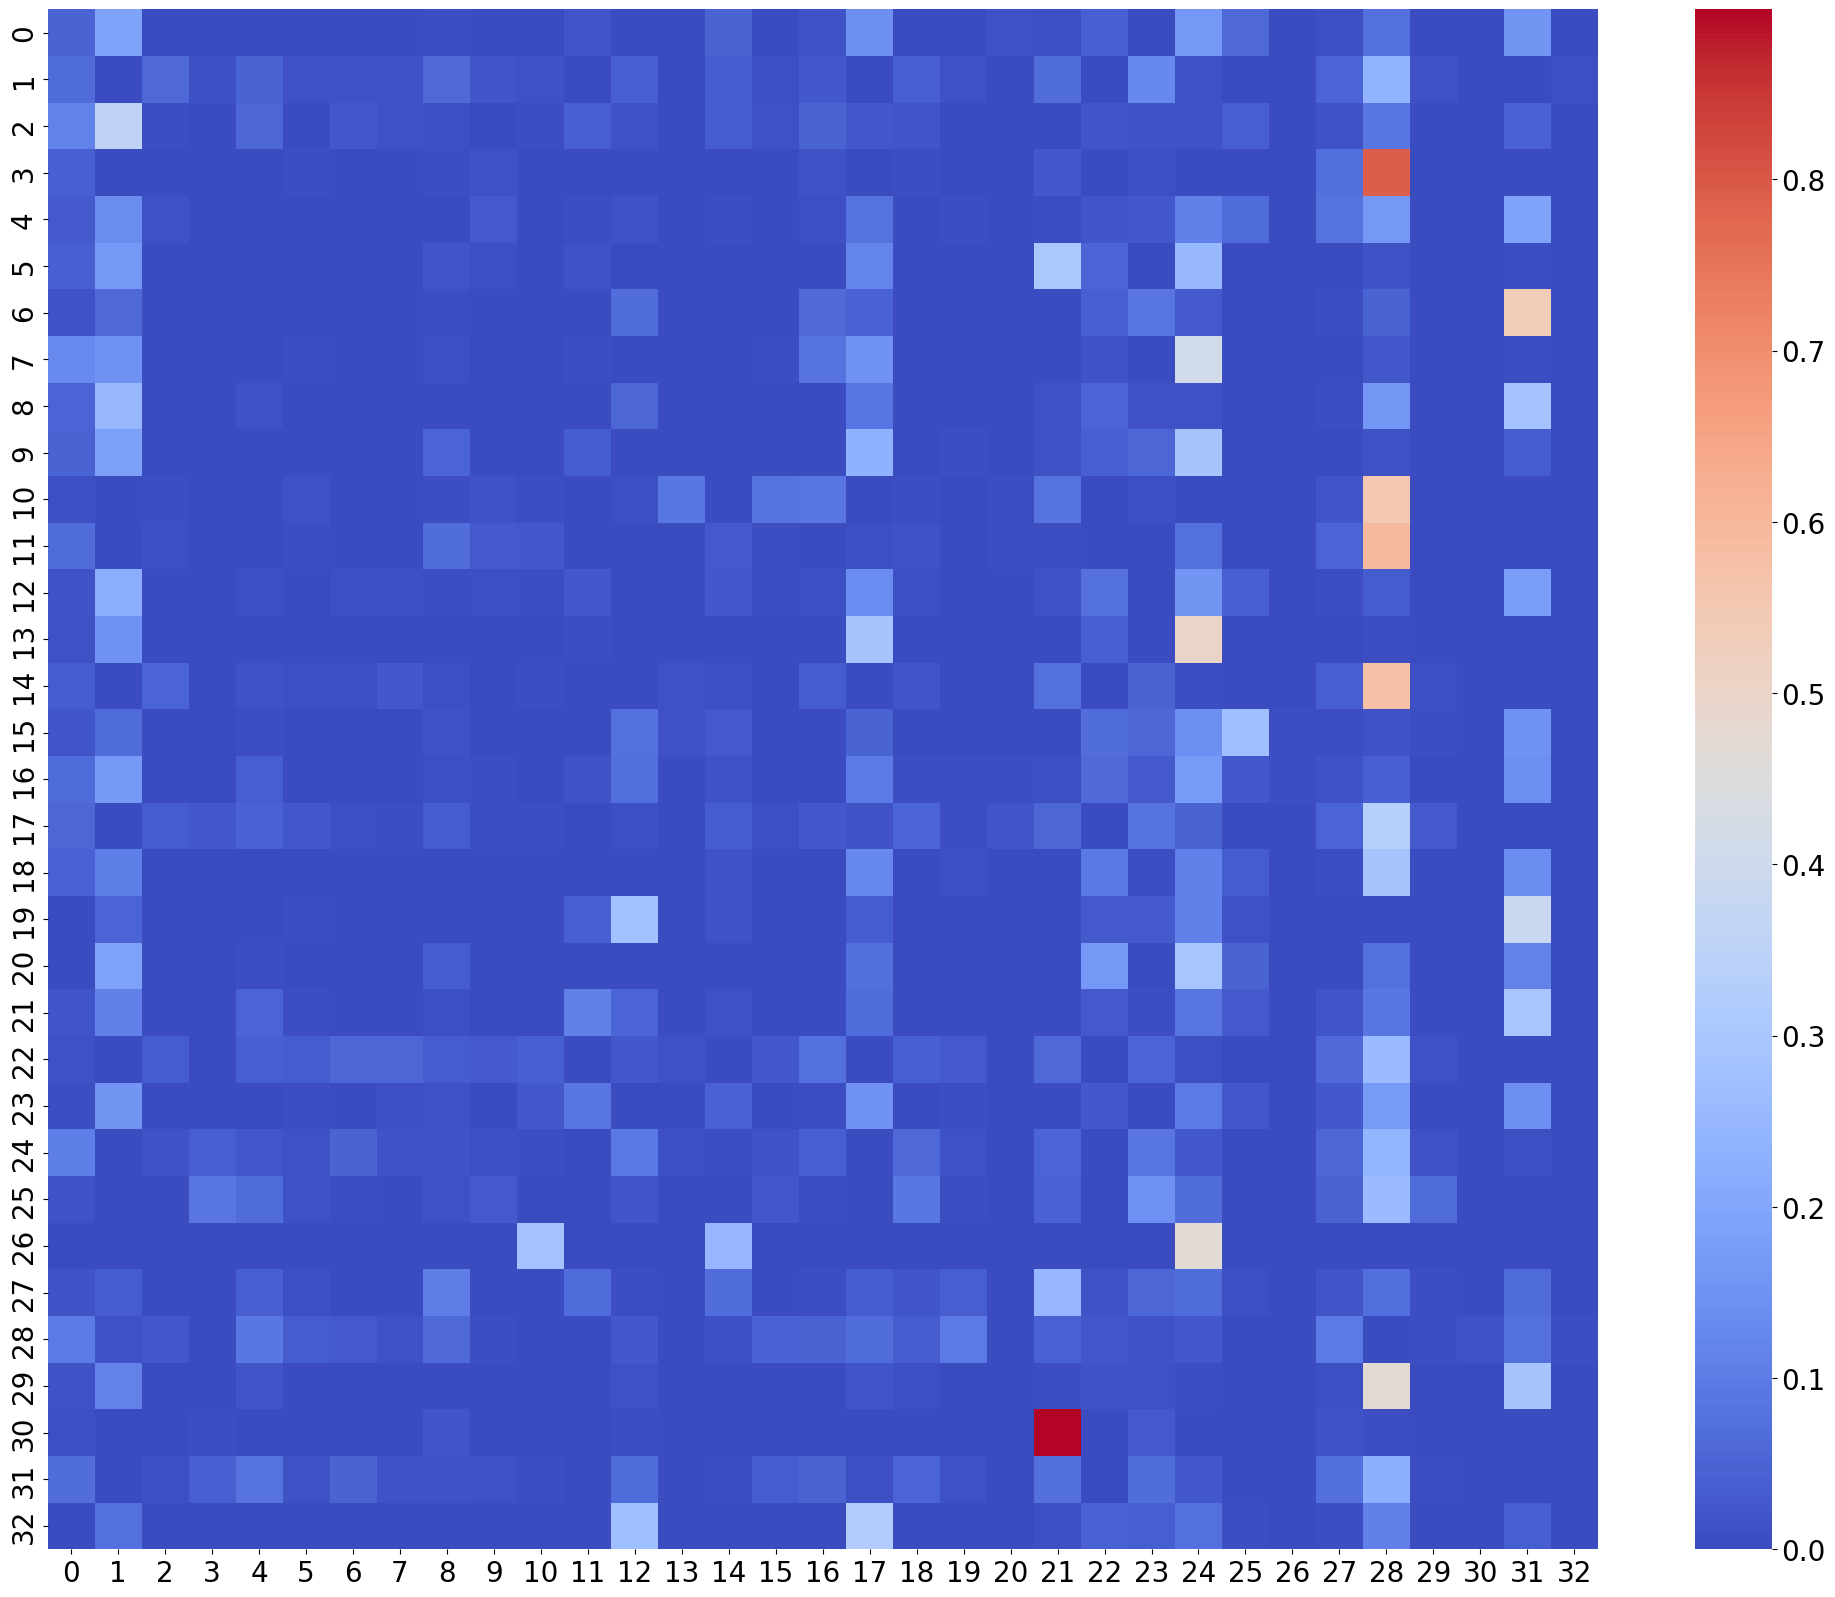

In [7]:
plt.figure(figsize=(25,20))
plt.rcParams.update({'font.size': 20})
sns.heatmap(probabilities, 
        xticklabels=range(len(symbols.keys())),
        yticklabels=range(len(symbols.keys())), cmap='coolwarm')

In [8]:
# выведем все варианты, в которых 4 символа из нашего словаря следуют друг за другом в тексте, 
# а также начинаются с "п" и заканчиваются на "р" 
start = symbols['п']
end = symbols['р']
prior = 1. / len(symbols)
i=0
j=0
combinations=[]
combinations_dict={}
for s1 in symbols.keys():
    for s2 in symbols.keys():
        proba = prior * probabilities[start, symbols[s1]] * probabilities[symbols[s1], symbols[s2]] \
        * probabilities[symbols[s2], end]
        j+=1
        if proba > 0:
            combinations_dict.setdefault(''.join(['п', s1, s2, 'р']), proba)
            combinations.append(''.join(['п', s1, s2, 'р']))
            i+=1
print(f'всего было {len(combinations)} таких комбинаций вероятностью > 0')
print(f'суммарная вероятность встретить строку по нашим условиям {sum(combinations_dict.values())}')

print('\nTOP 5 комбинаций по вероятности:')
{i: j for i,j in enumerate(sorted(combinations_dict.items(), key=lambda kv: kv[1], reverse=True)) if i<5}

всего было 654 таких комбинаций вероятностью > 0
суммарная вероятность встретить строку по нашим условиям 0.0009859389863502764

TOP 5 комбинаций по вероятности:


{0: ('прер', 0.0001234918479377439),
 1: ('прор', 9.424559983370175e-05),
 2: ('прар', 7.661798413479925e-05),
 3: ('по р', 6.532605001638598e-05),
 4: ('потр', 4.362875328462006e-05)}

In [9]:
# сгененрируем слово из 8 букв по нашей матрице вероятностей, начинающееся с буквы "б"
s = []
start = 'б'
s.append(start)
length = 8
for i in range(length):
    index = symbols[s[i]]
    next_char = np.random.choice(list(symbols.keys()), p=probabilities[index])
    s.append(next_char)

print (''.join(s))

бабъягоня


### HMM

In [16]:
# возмем датасет с Пассажирами международных авиакомпаний
series=pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv").iloc[:,-1]
series.head()

0    890.19
1    901.80
2    888.51
3    887.78
4    858.43
Name: Close, dtype: float64

In [17]:
series = series.values.reshape(-1, 1)
series[:10]

array([[890.19],
       [901.8 ],
       [888.51],
       [887.78],
       [858.43],
       [850.61],
       [856.02],
       [880.91],
       [908.15],
       [912.75]])

In [18]:
best_model = []
for n in range(1, 15):
    model = hmm.GaussianHMM(n_components=n, covariance_type="full", n_iter=500)
    model.fit(series)
    best_model.append(model.score(series))
print(f'лучший результат {max(best_model)} был при n_components={np.argmax(best_model)+1}')

Fitting a model with 167 free scalar parameters with only 162 data points will result in a degenerate solution.
Fitting a model with 194 free scalar parameters with only 162 data points will result in a degenerate solution.
Fitting a model with 223 free scalar parameters with only 162 data points will result in a degenerate solution.


лучший результат -702.8325670896587 был при n_components=14


Fitting a model with 223 free scalar parameters with only 162 data points will result in a degenerate solution.


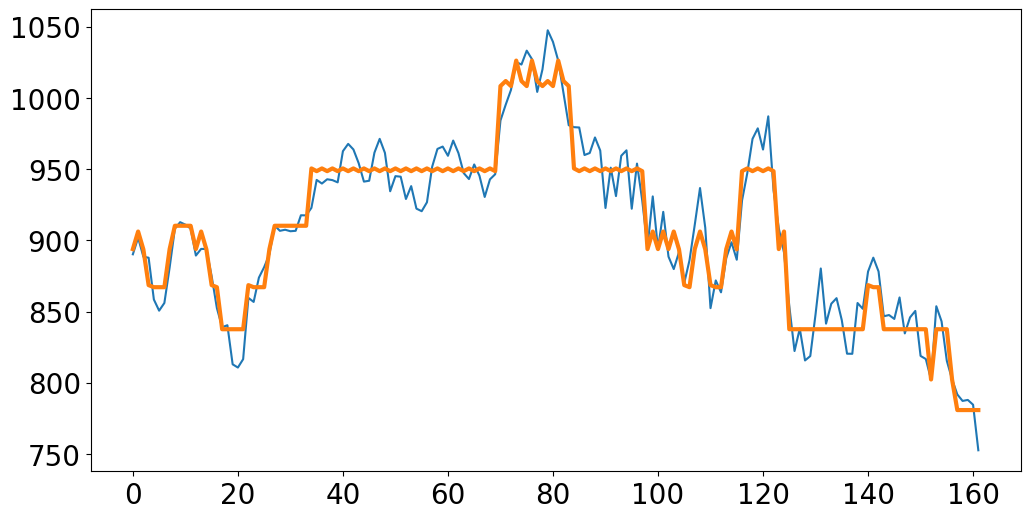

In [19]:
# построим модель на полученных данных
model = GaussianHMM(n_components=14, covariance_type="full", n_iter=500)
model.fit(series)
labels = model.predict(series)
means = np.zeros_like(series)
for i in range(model.n_components):
    means[labels == i] = model.means_[i]
    
plt.figure(figsize=(12, 6))
plt.plot(series)
plt.plot(means, linewidth=3)

In [20]:
from sklearn.metrics import r2_score
r2_score(y_pred=means, y_true=series)

0.9348258158644516

### ВЫВОДЫ:
У нас получились неплохие показатели модели